In [24]:
import GPy
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from osprey.config import Config
from os.path import join, basename
from glob import glob


In [99]:
# import database
# Function to apply
def f(x, ss_mapping):
    var_names = ss_mapping[x['project_name']]
    values = [x['parameters'][var_name] for var_name in var_names]
    return values

def g(x, ss_mapping):
    var_names = list(ss_mapping[x['project_name']])
    return var_names

all_dfs = []
strategies = ['Random', 'Sobol']
for strategy in strategies:
    # Get features
    features = glob(join(strategy, '*.yaml'))
    features = [basename(feat) for feat in features]
    
    # DFs is for whole database so only get this once. 
    config = Config(join(strategy, features[0]))
    df = config.trial_results()
    df['strategy'] = strategy 
    df['values'] = 0.0
    
    # Now make the mapping
    ss_mapping = {}
    for feature in features:
        config = Config(join(strategy, feature))
        ss = config.get_section('search_space')
        pname = config.get_section('trials')['project_name']
        
        if pname != feature.split('.')[0]:
            print('Error!', feature, pname)
            continue
 
        var_names = list(ss.keys())
        ss_mapping[pname] = np.sort(var_names)    
    df['values'] = df.apply(f, axis=1, args=(ss_mapping, ))
    df['ss_dim'] = df.loc[:, 'values'].apply(func=lambda x: len(x))
    df['params'] = df.apply(g, axis=1, args=(ss_mapping,))
    all_dfs.append(df)
df = pd.concat(all_dfs)

Loading config file:     Random/all_tor.yaml...
Loading trials database: sqlite:///osprey-trails.db...
Loading config file:     Random/all_tor.yaml...
Loading config file:     Random/alpha_angle.yaml...
Loading config file:     Random/b-cont_ca.yaml...
Loading config file:     Random/b-cont_closest-heavy.yaml...
Loading config file:     Random/b-cont_closest.yaml...
Loading config file:     Random/chi_tor.yaml...
Loading config file:     Random/cont_ca.yaml...
Loading config file:     Random/cont_closest-heavy.yaml...
Loading config file:     Random/cont_closest.yaml...
Loading config file:     Random/drid.yaml...
Loading config file:     Random/kappa_angle.yaml...
Loading config file:     Random/l-cont_ca.yaml...
Loading config file:     Random/l-cont_closest-heavy.yaml...
Loading config file:     Random/l-cont_closest.yaml...
Loading config file:     Random/pp_tor.yaml...
Loading config file:     Random/ppo_tor.yaml...
Loading config file:     Sobol/all_tor.yaml...
Loading trials dat

In [100]:
df = df.loc[(df['status']=='SUCCEEDED') & (df['project_name']!='all_tor'), 
            ['mean_test_score', 'project_name', 'strategy', 'values', 'ss_dim', 'params']]

In [101]:
df.head()

,mean_test_score,project_name,strategy,values,ss_dim,params
0,2.001252,alpha_angle,Random,"[990, 228, 10]",3,"[cluster__n_clusters, tica__lag_time, tica__n_..."
1,2.303891,alpha_angle,Random,"[547, 247, 5]",3,"[cluster__n_clusters, tica__lag_time, tica__n_..."
2,2.815396,b-cont_ca,Random,"[371, 1.3481152833501795, 134, 2]",4,"[cluster__n_clusters, feature__cutoff, tica__l..."
3,2.294570,alpha_angle,Random,"[371, 196, 5]",3,"[cluster__n_clusters, tica__lag_time, tica__n_..."
5,2.148784,alpha_angle,Random,"[719, 130, 8]",3,"[cluster__n_clusters, tica__lag_time, tica__n_..."


# Variable Importance  - Random Strategy Data
Bootstrap distribution of lengthscales from ARD with RBF kernel

In [114]:
data = df.loc[df['strategy']=='Random', :]


In [122]:
n_bs = 100 # Number of bootstrap samples
frac_bs = 0.8 # Size of bootstrap samples as fraction of the amount of data. 
lmin, lmax = 0.1, 10 # Min/max of the values to initialize the kernel lengthscales to. 

def get_bs(X, Y):
    
    # Scale data
    scaler = MinMaxScaler()
    scaler.fit(X)
    Xs = scaler.transform(X)
    
    # Set up data structure
    relevance = np.zeros((n_bs, X.shape[1]))
    
    # BS loop
    for i in range(n_bs):
        x, y = resample(Xs,Y, random_state=int(i), n_samples=int(Y.shape[0]*frac_bs))
        
        kernel= GPy.kern.RBF(input_dim=x.shape[1], ARD=True, 
                         lengthscale=np.random.uniform(lmin, lmax, x.shape[1]))
        m = GPy.models.GPRegression(x,y,kernel)
        m.optimize()
        lens = np.array([x for x in kernel.lengthscale])
        relevance[i] = 1./lens 
    return relevance



In [151]:
grp = data.groupby(['ss_dim'])
for ss_dim, group in grp:
    relevance = {}
    cols = group['params'].values[0]

    grp2 = group.groupby(['project_name'])
    relevance = {}
    for feat, group2 in grp2:
        X = np.array(group2['values'].values)
        Y = np.array(group2['mean_test_scores'].values)
        X = np.array([X[i] for i in range(len(X))])
        results = get_bs(X, Y)
        
        

alpha_angle (207, 3)
chi_tor (200, 3)
cont_ca (207, 3)
cont_closest (207, 3)
cont_closest-heavy (200, 3)
kappa_angle (206, 3)
pp_tor (200, 3)
ppo_tor (200, 3)
b-cont_ca (206, 4)
b-cont_closest (200, 4)
b-cont_closest-heavy (200, 4)
l-cont_ca (205, 5)
l-cont_closest (206, 5)
l-cont_closest-heavy (202, 5)


In [150]:

X.shape

(202, 5)

In [200]:
from sklearn.utils import resample
num_bs = 100
relevance = np.zeros((num_bs, X.shape[1]))

for i in range(num_bs):
    # Bootstrap
    x, y = resample(Xs,Y, random_state=int(i), n_samples=int(Y.shape[0]*0.8))
#     kerns = [GPy.kern.Matern52(1, lengthscale=np.random.uniform(low=0.1, high=10.0, size=1), active_dims=[i]) 
#             for i in range(3)]
#     kernel=np.sum(kerns)
    kernel = GPy.kern.RBF(3, ARD=True, lengthscale=np.random.uniform(low=1, high=10.0, size=3))
    m = GPy.models.GPRegression(x,y,kernel)
    m.optimize()
    lens = np.array([x for x in kernel.lengthscale])
    relevance[i] = 1./lens  
    


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


In [201]:
relevance = pd.DataFrame(relevance, columns=variables)
relevance.head()

,tica__lag_time,tica__n_components,cluster__n_clusters
0,0.105876,0.549834,0.026100
1,0.101922,0.843204,0.032468
2,0.218427,0.933881,0.064363
3,0.165393,0.714842,0.036652
4,0.071547,0.464386,0.034650


In [202]:
melt_relevance = pd.melt(relevance)
melt_relevance.head()

,variable,value
0,tica__lag_time,0.105876
1,tica__lag_time,0.101922
2,tica__lag_time,0.218427
3,tica__lag_time,0.165393
4,tica__lag_time,0.071547


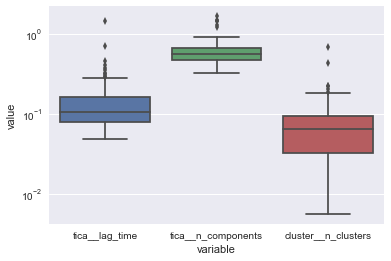

In [204]:
ax = sns.boxplot(x='variable', y='value', data=melt_relevance)
# ax.set_((0,0.1))
ax.set_yscale('log')

In [192]:
for i in range(10):
    x, y = resample(Xs,Y, random_state=i, n_samples=5)
    print(x)
    print()

[[ 0.20080321  0.          0.16804979]
 [ 0.53815261  0.55555556  0.94502075]
 [ 0.88353414  0.88888889  0.76244813]
 [ 0.46987952  0.11111111  0.38070539]
 [ 0.18473896  0.88888889  0.69605809]]

[[ 0.73895582  0.11111111  0.03008299]
 [ 0.36947791  0.66666667  0.45643154]
 [ 0.          0.44444444  0.8246888 ]
 [ 1.          0.55555556  0.90560166]
 [ 0.96787149  0.33333333  0.32676349]]

[[ 0.38554217  0.66666667  0.70850622]
 [ 0.53815261  0.33333333  0.06742739]
 [ 0.          0.44444444  0.8246888 ]
 [ 0.85140562  0.22222222  0.59854772]
 [ 0.70281124  0.55555556  0.4346473 ]]

[[ 0.94779116  0.22222222  0.97095436]
 [ 0.79919679  0.44444444  0.99377593]
 [ 0.92369478  0.11111111  0.04460581]
 [ 0.81927711  0.          0.07780083]
 [ 0.5502008   0.88888889  0.01244813]]

[[ 0.02008032  0.66666667  0.47821577]
 [ 0.86746988  0.55555556  0.84543568]
 [ 0.7751004   0.55555556  0.77178423]
 [ 0.59437751  0.66666667  0.35580913]
 [ 0.90361446  0.66666667  0.56120332]]

[[ 0.37349398  